# Chicago Car Crash Dataset<br>

* Student name: Bonny Nichol
* Student pace: Self Paced
* Scheduled project review date/time: November 17, 2020
* Instructor name: Jeff Herman
* Blog post URL: https://bonnynichol.medium.com/chicago-traffic-crashes-7a3412584629


The Chicago Car Crashes dataset is an open source dataset pulled from the Chicago Data Portal offered by the City of Chicago. The dataset for this project was pulled from the Chicago Data Portal on November 8, 2020. This project attempts to discover which car crash features are most associated with fatal crashes by using machine learning (particularly concentrating on Decision Tree models, Ensemble Methods, and Hypertuning parameters). The information learned from this available dataset and from the machine learning models can be applicable to a Vehicle Safety Board to advise on how to create safer roads. 

## Import Libraries

In [8]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

#from yellowbrick.classifier import ConfusionMatrix
import xgboost as xgb

## Load Data

In [9]:
# load dataset
df = pd.read_csv('crashes.csv')
df.head()

CRASH_RECORD_ID     RD_NO  \
0  073682ef84ff827659552d4254ad1b98bfec24935cc9cc...  JB460108   
1  1560fb8a1e32b528fef8bfd677d2b3fc5ab37278b157fa...  JC325941   
2  c7e667807d86ff2e83da48267e1135680cad68c86eb00f...  JD150617   
3  009e9e67203442370272e1a13d6ee51a4155dac65e583d...  JA329216   
4  00e47f189660cd8ba1e85fc63061bf1d8465184393f134...  JC194776   

  CRASH_DATE_EST_I              CRASH_DATE  POSTED_SPEED_LIMIT  \
0              NaN  10/02/2018 06:30:00 PM                  10   
1              NaN  06/27/2019 04:00:00 PM                  45   
2              NaN  02/13/2020 04:30:00 PM                  30   
3              NaN  06/30/2017 04:00:00 PM                  35   
4              NaN  03/21/2019 10:50:00 PM                  30   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0            NO CONTROLS           NO CONTROLS             CLEAR   
1            NO CONTROLS           NO CONTROLS             CLEAR   
2            NO CONTROLS           NO CONTROLS             CLEAR   
3      STOP SIGN/FLASHER  FUNCTIONING PROPERLY             CLEAR   
4         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   

       LIGHTING_CONDITION          FIRST_CRASH_TYPE  ...  \
0                DARKNESS      PARKED MOTOR VEHICLE  ...   
1                DAYLIGHT  SIDESWIPE SAME DIRECTION  ...   
2                DAYLIGHT  SIDESWIPE SAME DIRECTION  ...   
3                DAYLIGHT                   TURNING  ...   
4  DARKNESS, LIGHTED ROAD                   TURNING  ...   

  INJURIES_NON_INCAPACITATING  INJURIES_REPORTED_NOT_EVIDENT  \
0                         0.0                            0.0   
1                         0.0                            0.0   
2                         0.0                            1.0   
3                         0.0                            0.0   
4                         0.0                            0.0   

  INJURIES_NO_INDICATION INJURIES_UNKNOWN CRASH_HOUR CRASH_DAY_OF_WEEK  \
0                    1.0              0.0         18                 3   
1                    2.0              0.0         16                 5   
2                    2.0              0.0         16                 5   
3                    3.0              0.0         16                 6   
4                    2.0              0.0         22                 5   

  CRASH_MONTH   LATITUDE  LONGITUDE                                  LOCATION  
0          10        NaN        NaN                                       NaN  
1           6        NaN        NaN                                       NaN  
2           2        NaN        NaN                                       NaN  
3           6  41.741804 -87.740954  POINT (-87.740953581987 41.741803598989)  
4           3  41.741804 -87.740954  POINT (-87.740953581987 41.741803598989)  

[5 rows x 49 columns]

In [10]:
# Make a copy for geo maps
geo = df.copy()

## Data Exploration

We can quickly assess that the dataset contains 453873 rows of data with 49 columns. This is probably too many features for our model later so we will want to assess how much data is missing in these columns and how applicable they are to the model.

In [11]:
# Shape of dataset
df.shape

(453873, 49)

In [12]:
df.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

There are a few columns that are missing a lot of data. Instead of filling in this missing data with either an 'Unknown' category or replacing the Null values with zero, we will instead create a new dataframe later from the features we will want to use and deal with missing data then.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453873 entries, 0 to 453872
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                453873 non-null  object 
 1   RD_NO                          450376 non-null  object 
 2   CRASH_DATE_EST_I               33749 non-null   object 
 3   CRASH_DATE                     453873 non-null  object 
 4   POSTED_SPEED_LIMIT             453873 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         453873 non-null  object 
 6   DEVICE_CONDITION               453873 non-null  object 
 7   WEATHER_CONDITION              453873 non-null  object 
 8   LIGHTING_CONDITION             453873 non-null  object 
 9   FIRST_CRASH_TYPE               453873 non-null  object 
 10  TRAFFICWAY_TYPE                453873 non-null  object 
 11  LANE_CNT                       198959 non-null  float64
 12  ALIGNMENT                     

Fatal injuries is our target variable and therefore we only want to work with available data rows in this column.

In [14]:
df = df.dropna(axis=0, subset=['INJURIES_FATAL'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452981 entries, 0 to 453872
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                452981 non-null  object 
 1   RD_NO                          449489 non-null  object 
 2   CRASH_DATE_EST_I               33566 non-null   object 
 3   CRASH_DATE                     452981 non-null  object 
 4   POSTED_SPEED_LIMIT             452981 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         452981 non-null  object 
 6   DEVICE_CONDITION               452981 non-null  object 
 7   WEATHER_CONDITION              452981 non-null  object 
 8   LIGHTING_CONDITION             452981 non-null  object 
 9   FIRST_CRASH_TYPE               452981 non-null  object 
 10  TRAFFICWAY_TYPE                452981 non-null  object 
 11  LANE_CNT                       198607 non-null  float64
 12  ALIGNMENT                     

Briefly looking at this column, we can see an inbalance of non-fatal and fatal accidents. We will account for this later with a class_weight parameter in our decision tree models.

In [15]:
df['INJURIES_FATAL'].value_counts()

0.0    452545
1.0       405
2.0        25
3.0         5
4.0         1
Name: INJURIES_FATAL, dtype: int64

We can see there are 5 different types of crash under the "INJURIES_FATAL" column.<br><br>
0.0 - Crash was not fatal<br>
1.0 - One person was killed<br>
2.0 - Two people were killed<br>
3.0 - Three people were killed<br>
4.0 - Four people were killed<br><br>
Because a crash is a fatal crash whether one person or 4 people die in it, I will group these into two categories, 0 - not fatal, 1 - fatal

In [16]:
df['fatal'] = df['INJURIES_FATAL'].map(lambda x: 0 if x == 0 else 1)
df['fatal']
fatal = df['fatal']
fatal

0         0
1         0
2         0
3         0
4         0
         ..
453868    0
453869    0
453870    0
453871    0
453872    0
Name: fatal, Length: 452981, dtype: int64

Taking a look at the columns, we can begin to understand what kind of data we will want to use as features in our models.

In [17]:
df.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

## Plotting Geographical Data

Visualizing the location of the non-fatal (serious), non-fatal (not serious), and fatal accidents overlaid on a map of Chicago is an important tool to understand which parts of towns are more impacted by traffic accidents. This is valuable knowledge for a Vehicle Safety Board to be able to implement task teams to these areas most impacted to help prevent future accidents.

In [18]:
geo = geo[['LATITUDE', 'LONGITUDE', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING']]
geo = geo.dropna(axis=0, subset=['INJURIES_FATAL'])
geo = geo.dropna(axis=0, subset=['LONGITUDE'])
geo = geo.dropna(axis=0, subset=['LATITUDE'])
geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450524 entries, 3 to 453872
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   LATITUDE                     450524 non-null  float64
 1   LONGITUDE                    450524 non-null  float64
 2   INJURIES_FATAL               450524 non-null  float64
 3   INJURIES_INCAPACITATING      450524 non-null  float64
 4   INJURIES_NON_INCAPACITATING  450524 non-null  float64
dtypes: float64(5)
memory usage: 20.6 MB


Geopandas converts data into point geometry and overlays this geometry onto a shape file of a map of Chicago.

In [19]:
neigh_map = gpd.read_file('geo_export_aeab7300-7d09-4aec-ad13-b05f99ccc606.shp')
crs = {'init': 'epsg:4326'}

In [20]:
geometry = [Point(xy) for xy in zip(geo['LONGITUDE'], geo['LATITUDE'])]
geometry[5:8]
geo_df = gpd.GeoDataFrame(geo, crs = crs, geometry = geometry)
#geo_data = geo_data[geo_data.LATITUDE > 0.0]
#geo_data.info()

We can see in our first map showing fatal accidents that the accidents are sprinkled throughout Chicago yet there are still certain zones that have a higher rate of fatal accidents.

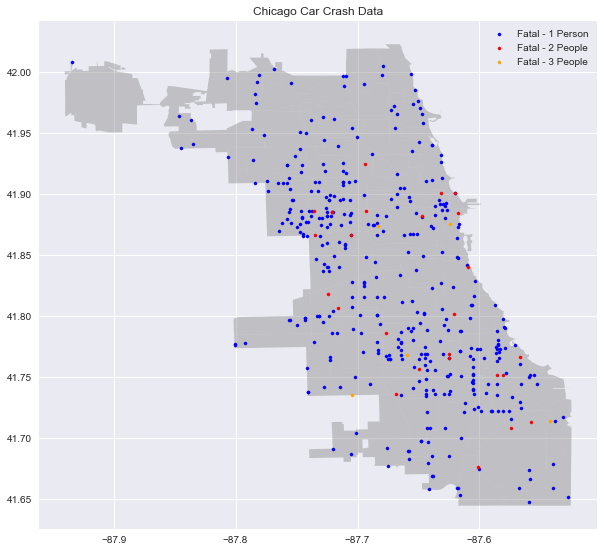

In [21]:
#Plotting fatal injuries
fig, ax = plt.subplots(figsize = (10,10))
neigh_map.plot(ax = ax, alpha = 0.4, color='grey')
geo_df[geo_df['INJURIES_FATAL'] == 1.0].plot(ax = ax, markersize = 10, color='blue', marker='o', label = 'Fatal - 1 Person')
geo_df[geo_df['INJURIES_FATAL'] == 2.0].plot(ax = ax, markersize = 10, color='red', marker='o', label = 'Fatal - 2 People')
geo_df[geo_df['INJURIES_FATAL'] == 3.0].plot(ax = ax, markersize = 10, color='orange', marker='o', label = 'Fatal - 3 People')
plt.title('Chicago Car Crash Data')
plt.legend(prop={'size': 10})

The below map shows non-fatal but serious injuries. These injuries were disabling and the person in the accident was not able to walk away from it. This data is also very valuable to visualize because even though the accident was not fatal, it was still an accident that impacted someone's life. As we can see in the below map, the areas of high rate of non-fatal serious accidents align with the areas of fatal accidents. This is very valuable information for the Vehicle Safety Board in order to target these areas to avoid future serious accidents.

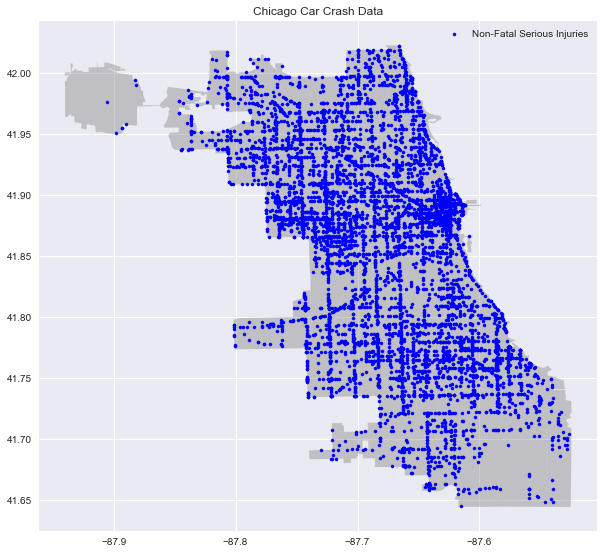

In [22]:
#Plotting non-fatal but serious injuries
geo_df = geo_df[geo_df['LATITUDE'] != 0]
fig, ax = plt.subplots(figsize = (10,10))
neigh_map.plot(ax = ax, alpha = 0.4, color='grey')
geo_df[geo_df['INJURIES_INCAPACITATING'] == 1.0].plot(ax = ax, markersize = 10, color='blue', marker='o', label = 'Non-Fatal Serious Injuries')
plt.title('Chicago Car Crash Data')
plt.legend(prop={'size': 10})

The final map below shows non-fatal and not serious accidents. These accidents are a larger majority of the dataset but also show the same areas of chicago that have a higher rate of car crashes.

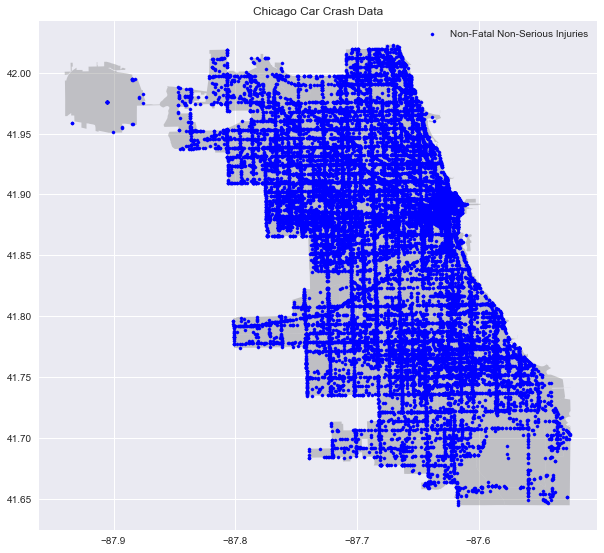

In [23]:
#Plotting non-fatal and non-serious injuries
fig, ax = plt.subplots(figsize = (10,10))
neigh_map.plot(ax = ax, alpha = 0.4, color='grey')
geo_df[geo_df['INJURIES_NON_INCAPACITATING'] == 1.0].plot(ax = ax, markersize = 10, color='blue', marker='o', label = 'Non-Fatal Non-Serious Injuries')
plt.title('Chicago Car Crash Data')
plt.legend(prop={'size': 10})

## Label Encoding Features

Label encoding is necessary for the ML alogorithms because the ML models need the categorical variables transformed into numerical values. At this time, we will also choose the feature columns we are most interested to use later in the models.

In [24]:
text_col = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION','LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 
            'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR','CRASH_DAY_OF_WEEK', 'CRASH_MONTH']
encode_df = pd.DataFrame()
for col in text_col:
    encoder = LabelEncoder()
    encode_df[col] = encoder.fit_transform(df[col])
    
encode_df

TRAFFIC_CONTROL_DEVICE  DEVICE_CONDITION  WEATHER_CONDITION  \
0                            4                 3                  2   
1                            4                 3                  2   
2                            4                 3                  2   
3                           15                 1                  2   
4                           16                 1                  2   
...                        ...               ...                ...   
452976                      15                 1                  2   
452977                       4                 3                  3   
452978                      15                 1                  2   
452979                       4                 3                  2   
452980                       4                 3                  2   

        LIGHTING_CONDITION  FIRST_CRASH_TYPE  TRAFFICWAY_TYPE  \
0                        0                 7               11   
1                        3                15               10   
2                        3                15               10   
3                        3                17                8   
4                        1                17                8   
...                    ...               ...              ...   
452976                   3                17                2   
452977                   3                17                3   
452978                   3                 3                2   
452979                   3                 7               10   
452980                   3                 7               10   

        ROADWAY_SURFACE_COND  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH  
0                          0          18                  2            9  
1                          0          16                  4            5  
2                          6          16                  4            1  
3                          0          16                  5            5  
4                          0          22                  4            2  
...                      ...         ...                ...          ...  
452976                     0           9                  2            6  
452977                     0          17                  3            6  
452978                     0          10                  3            6  
452979                     0          14                  3            6  
452980                     0           9                  3            6  

[452981 rows x 10 columns]

In [25]:
# Merge the two dataframes together
df2 = pd.merge(fatal, encode_df, left_index=True, right_index=True)

We can see now we have one consistent DF with no missing values and all the types are the same.

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452089 entries, 0 to 452980
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   fatal                   452089 non-null  int64
 1   TRAFFIC_CONTROL_DEVICE  452089 non-null  int64
 2   DEVICE_CONDITION        452089 non-null  int64
 3   WEATHER_CONDITION       452089 non-null  int64
 4   LIGHTING_CONDITION      452089 non-null  int64
 5   FIRST_CRASH_TYPE        452089 non-null  int64
 6   TRAFFICWAY_TYPE         452089 non-null  int64
 7   ROADWAY_SURFACE_COND    452089 non-null  int64
 8   CRASH_HOUR              452089 non-null  int64
 9   CRASH_DAY_OF_WEEK       452089 non-null  int64
 10  CRASH_MONTH             452089 non-null  int64
dtypes: int64(11)
memory usage: 41.4 MB


In [27]:
df2.columns

Index(['fatal', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'],
      dtype='object')

Visualizing the data before the ML model is helpful to see the distribution of the values within each column.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f950a4e48>,
      dtype=object)

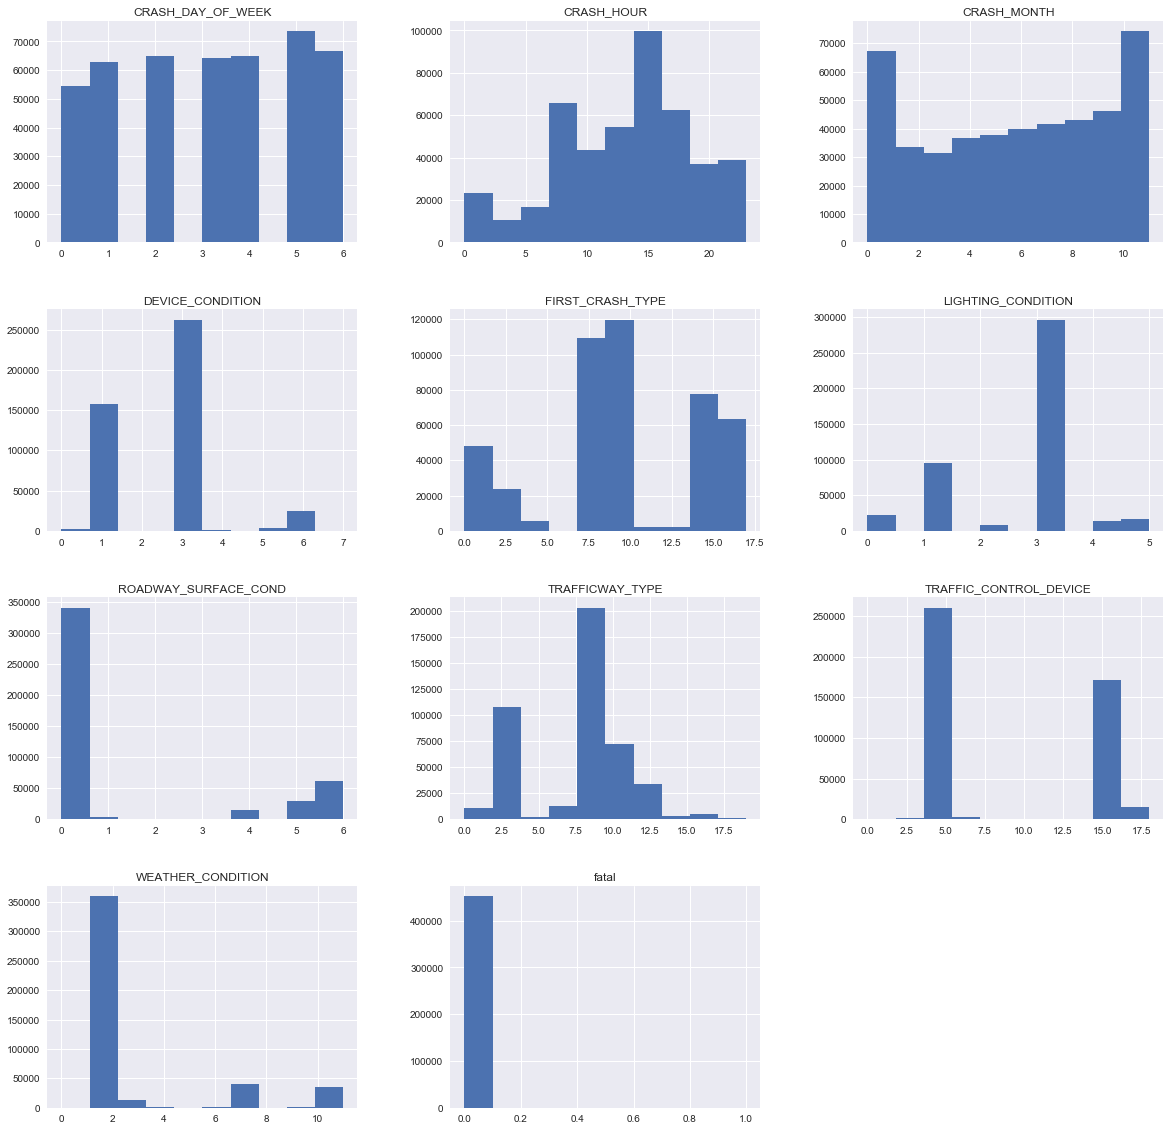

In [28]:
df2.hist(bins=10, figsize=(20,20))

## Train and Test Split

In [29]:
# Create features and labels
y = df2['fatal']
X = df2.drop(['fatal'], axis=1)

In [30]:
# Perform an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=10)

## Decision Tree Classifier

A Decision Tree Classifier is a useful ML tool for this dataset because it uses discrete variables as input (encoded from our categorical variables) and is one of the most powerful (and oldest!) tools in machine learning. The results of Decision Trees are also easier to understand than more complex models. The general idea of the Decision Tree model is that it uses recursive partioning of the space in order to check for conditions and performs a decision at each node.<br><br>For the parameters of the decision tree, I will use class_weight = balanced to account for the sample sizes being misbalanced. There are much less fatal crashes than non-fatal crashes. I will also use max_depth=5 because without this parameter, the model is completely overfit. Later on with Hypertuning the parameters, we will explore these parameters more to find the best fit for the model.

In [31]:
# Train a DT classifier
classifier1 = DecisionTreeClassifier()
classifier1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

We will use the above classifier for the base of our gridsearch later on but we already know we will need to have a class_weight to this dataset as well as a max_depth before analyzing accuracy.

In [32]:
classifier = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=10)  
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [33]:
# Make predictions for test data
y_pred = classifier.predict(X_test) 

In [34]:
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print('Accuracy of model fitted to test set is :{0}'.format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy of model fitted to test set is :49.71465858567984

AUC is :0.55

Confusion Matrix
----------------


Predicted      0      1    All
True                          
0          44897  45430  90327
1             37     54     91
All        44934  45484  90418

In [35]:
# from yellowbrick.classifier import ConfusionMatrix

# cm = ConfusionMatrix(
#     classifier, classes=classes,
#     label_encoder={0: 'not fatal', 1: 'fatal'}
# )

# cm.show()

In [36]:
# Plot and show decision tree
plt.figure(figsize=(20,20), dpi=500)
tree.plot_tree(classifier, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

49.71% is not a very high accuracy score. I am going to do another quick decision tree with a different max_depth to try to understand if an increase in max_depth helps improve accuracy or not.

In [37]:
# Train a DT classifier
classifier_m = DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=10)  
classifier_m.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [38]:
# Make predictions for test data
y_pred_m = classifier_m.predict(X_test) 

In [39]:
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred_m) * 100
print('Accuracy of model fitted to test set is :{0}'.format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_m)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred_m, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy of model fitted to test set is :70.45942179654494

AUC is :0.5

Confusion Matrix
----------------


Predicted      0      1    All
True                          
0          63682  26645  90327
1             65     26     91
All        63747  26671  90418

Increasing the max_depth fits the model more so this is good to know when hypertuning the parameters later.

In [40]:
# Plot and show decision tree
plt.figure(figsize=(20,20), dpi=500)
tree.plot_tree(classifier_m, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

## DT Features Importance

In [41]:
classifier_m.feature_importances_

array([0.050575  , 0.07155656, 0.08917467, 0.09727974, 0.12985358,
       0.12528063, 0.04008408, 0.15067972, 0.09538733, 0.15012869])

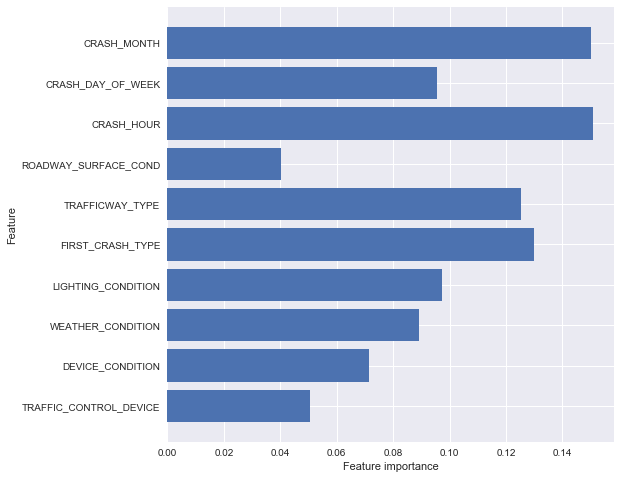

In [42]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(classifier_m)

## Decision Tree Using Entropy

Entropy is the measure of uncertainy. We will create a DT classifier using entropy instead of gini to see if this has a change in results. Gini does not use a logarithm in its formula and is less computationally heavy than Entropy. I will use the same parameters as Classifier_m model that created 70.45% accuracy.

In [43]:
# Instantiate and fit a DecisionTreeClassifier
classifier_2 = DecisionTreeClassifier(class_weight='balanced', random_state=10, criterion='entropy', max_depth=8)  
classifier_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [44]:
# Plot and show decision tree
plt.figure(figsize=(20,20), dpi=500)
tree.plot_tree(classifier_2, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

In [45]:
# Make predictions for test data
y_pred_2 = classifier_2.predict(X_test)

In [46]:
# Training accuracy score
classifier_2.score(X_train, y_train)

0.779108637408031

In [47]:
# Test accuracy score
classifier_2.score(X_test, y_test)

0.7774889955539827

Compared to DT Classifier with max_depth = 8 and using gini index, the DT Classifier using entropy scored almost 7% higher in accuracy.

## DT w/ Entropy Features Importance

In [48]:
classifier_2.feature_importances_

array([0.05491184, 0.06699658, 0.07125213, 0.11577924, 0.09932808,
       0.13645441, 0.05920045, 0.11685615, 0.10162231, 0.17759879])

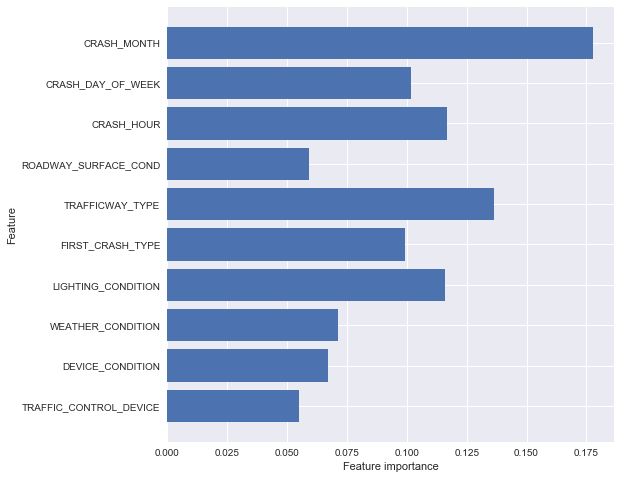

In [49]:
plot_feature_importances(classifier_2)

DT with Entropy places more emphasis on the feature "Crash Month" than does the original Classifier with max_depth = 8, gini.

## Bag of Trees

Bagged Decision Trees train on slightly different training sets allowing for minor differences and slightly different predictions. Bagging and Random Forest Classifiers attempt to remove complexities of a model that can overfit it. Boosting, in contrast, attempts to limit complexities in order to make sure a model is not underfit.

In [50]:
# Create a BaggingClassifier
bagtree =  BaggingClassifier(DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=10), 
                                 n_estimators=20)

In [51]:
# Fit to the training data
bagtree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='gini',
                                                        max_depth=8,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=10,
                                                        splitter='best'),
   

In [52]:
# Training accuracy score
bagtree.score(X_train, y_train)

0.8445714475310434

In [53]:
# Test accuracy score
bagtree.score(X_test, y_test)

0.8418456502023933

Compared to our original DT Classifier model with an accuracy of 70.45%, this Bagging ML has an increase of almost 15%!

## Bag of Trees Features Importance

In [54]:
from sklearn.tree import DecisionTreeClassifier
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagtree.estimators_
], axis=0)
print(feature_importances)

[0.04852936 0.07192666 0.04781997 0.04872306 0.10091059 0.12971459
 0.0596781  0.21926594 0.098509   0.17492272]


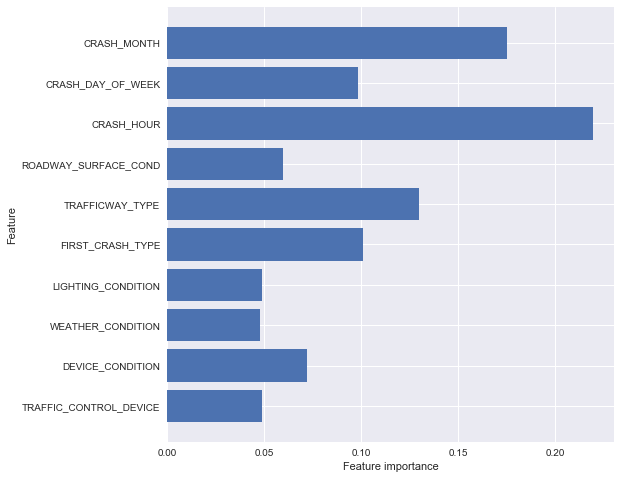

In [55]:
def plot_feature_importances_bag(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), feature_importances, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances_bag(bagtree)

## Random Forest Classifier

A Random Forest Classifier creates many decision trees using data samples and then takes the solution of each of them to select the best by voting.

In [56]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=10, n_estimators=20)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

In [57]:
# Training accuracy score
forest.score(X_train, y_train)

0.8746180921334583

In [58]:
# Test accuracy score
forest.score(X_test, y_test)

0.8732442655223518

In [60]:
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted      0      1    All
True                          
0          44897  45430  90327
1             37     54     91
All        44934  45484  90418

The accuracy score of the Random Forest Classifier is about 2% higher than the Bagging classifier model and about 17% than the original DT Classifier.

## Random Forest Features Importance

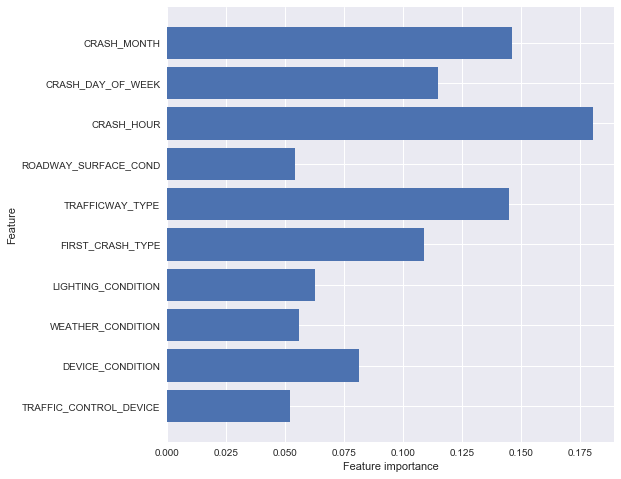

In [59]:
plot_feature_importances(forest)

# Hypertuning Parameters

## Grid Search - Decision Tree Classifier

In [ ]:
dt_param_grid = {
    'class_weight': ['balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [ ]:
num_decision_trees = 3 * 1* 2 * 6 * 3 * 6
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

In [ ]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(classifier1, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

In [ ]:
print(dt_grid_search.best_params_)

## Using Optimal Parameters - DT

In [ ]:
# Train a DT classifier
classifier_opt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', 
                                     max_depth=None, min_samples_leaf=1, min_samples_split=2)
classifier_opt.fit(X_train, y_train)

In [ ]:
plot_feature_importances(classifier_opt)

In [ ]:
# Training accuracy score
classifier_opt.score(X_train, y_train)

In [318]:
# Test accuracy score
classifier_opt.score(X_test, y_test)

0.9947576809927227

## Grid Search - Random Forest Classifier

In [273]:
rf_param_grid = {
    'class_weight': ['balanced'],
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [274]:
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 99.76%

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 10}


## Using Optimal Parameters - RF

In [61]:
# Creating Random Forest model using optimal parameters from grid search
forest_opt = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=None, random_state=10, 
                                    min_samples_leaf=3, min_samples_split=5, n_estimators=10)
forest_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

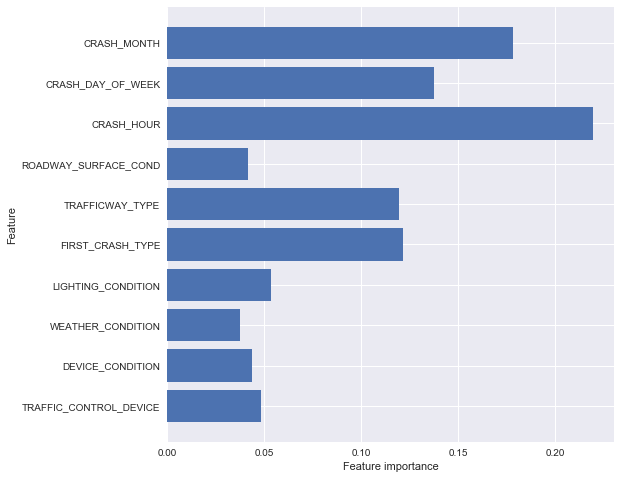

In [319]:
plot_feature_importances(forest_opt)

In [320]:
# Training accuracy score
forest_opt.score(X_train, y_train)

0.9971051038098161

In [321]:
# Test accuracy score
forest_opt.score(X_test, y_test)

0.9963281647459576

## DT and RF Grid Search - Comparison

In [275]:
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

Decision tree grid search:  0.994790860226946
Random forest grid search:  0.9963281647459576


## XGBoost

In [296]:
# define model
boost = xgb.XGBClassifier()

In [297]:
boost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [298]:
training_preds = boost.predict(X_train)
val_preds = boost.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 99.9%
Validation accuracy: 99.9%


In [418]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [421]:
boost_opt = GridSearchCV(boost, param_grid, scoring='accuracy', cv=None, n_jobs=-1)
boost_opt.fit(X_train, y_train)

best_parameters = boost_opt.best_params_

/Users/rosegold/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [2]:
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = boost_opt.predict(X_train)
val_preds = boost_opt.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 


NameError: name 'best_parameters' is not defined

In [426]:
# define model
boost_new = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7)
boost_new.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [428]:
training_preds = boost_new.predict(X_train)
val_preds = boost_new.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 99.9%
Validation accuracy: 99.9%


## Conclusions and Moving Forward

The Hour of a Crash has the biggest impact on fatal accidents. Potentially, the Vehicle Safety Board could advise for more officers to patrol during the hours or limiting speed limits during these hours to prevent more fatal accidents.

Geographic location indicates that certain areas are more likely to have fatal accidents. Conditions in these areas could be considered to see if there are any specific road problems that can be addressed.

Because this dataset is reliable (created from police reports) and also is constantly changing, I recommend that there be further and continuous review of this dataset to find more patterns that could help explain fatal (and also serious accidents).